In [1]:
#import sys
import matplotlib.animation as animation
#import time
import pylab as pl
from IPython import display
import numpy as np
import multiprocessing as mp
from numba import jit

In [2]:
import math

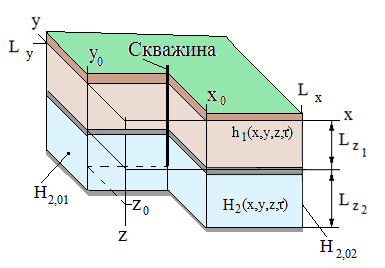

In [3]:
from IPython.display import Image
import matplotlib.pyplot as plt
Image("img_borning_place.png")

In [4]:
# Входные данные. Задаём номер варианта
N = 20
# 
Lx = 250 + 10*N
Ly = 200
Lz1 = 80 + N
Lz2 = 50 + 10*N

# начальные состояния невозмущенных грунтовых вод
H_201 = Lz1 + 10 + N #  м
H_202 = H_201 - 25
dH = H_201 - H_202
w = 0.00001 #c-1

In [5]:
print('Геометрические данные:  ','Lx = ',Lx,'  ','Ly = ',Ly,'  ','Lz1 = ',Lz1,'  ','Lz2 = ',Lz2,)

Геометрические данные:   Lx =  450    Ly =  200    Lz1 =  100    Lz2 =  250


In [6]:
# вычисление числа точек дискретизации по координатам
Nx = 9
Ny = 9
Nz1 = 9
Nz2 = 9

# Средняя точка водоносного пласта ?????????
x0 = 5 #Lx/2
y0 = 5 #Ly/2
z0 = 5 #Lz2/2

# Добывающая скважина осуществляет забор гидроминерального сырья «точке»
#Nx0 = 7
#Ny0 = 11
#Nz20 = 5

# Шаги дисретизации заданы
def step_d(L, N):
    return L/(N-1)

dx = step_d(Lx,Nx)
dy = step_d(Ly,Ny)
dz1 = step_d(Lz1,Nz1)
dz2 = step_d(Lz2,Nz2)


ch = 3600*24
# Дебит рассматриваемой скважины
Q = -100/ch# m^2/сут
K = 1#0.00191487*0.8847618*1.8196176619 # 0.001
V = K*Q

# Коэффициенты фильтрациии по соответствующим координатам
kx = np.array([0.198/ch, 0.146/ch])
ky = np.array([0.196/ch, 0.148/ch])
kz = np.array([0.148/ch, 0.024/ch])

# упругоемкость пласта
nu = 0.000581

# параметр перетекания, сут^(-1)
b1 = 0.0000035/ch 

In [7]:
@jit
def dirac_delta_function(x, y, z):
    return (1 if x == x0 and y == y0 and z == z0 else 0)

In [8]:
# задание 
h = np.zeros((Nx,Ny,Nz1))
H = np.zeros((Nx,Ny,Nz2))

Hk = np.zeros((Nx,Ny,Nz2))

del_h = np.zeros((Nx,Ny,Nz1))
del_H = np.zeros((Nx,Ny,Nz2))

In [9]:
for i in range(0,Nx,1):
    for j in range(0,Ny,1):       
        for s in range(0,Nz1,1):
            h[i][j][s] = s*dz1

In [10]:
for i in range(0,Nx):
    for j in range(0,Ny):
        for s in range(0,Nz2):
            H[i][j][s] = H_201 - dH*i/Nx
            Hk[i][j][s] = H[i][j][s]

In [11]:
@jit
def H_plus_dell(H, h,del_H,del_h, i, Ny, Nz1, Nz2):
    for j in range(1, Ny):
        for s in range(1, Nz1):
            H[i][j][s] = H[i][j][s] + del_H[i][j][s]
                #print(H[i][j][s])
        for s in range(1, Nz2):
            h[i][j][s] = h[i][j][s] + del_h[i][j][s]
        H[i][j][Nz2-1] = H[i][j][Nz2-2]
    return H, h

In [12]:
@jit
def narsan(del_H, i, j, dtau, kx, ky, kz, H, dx, dy, dz1,V):
    for s in range(1, Nz1-1):
        del_H[i][j][s] = (dtau/nu)*(kx[1]*(H[i-1][j][s]-2*H[i][j][s]+H[i+1][j][s])/(dx*dx)
                                    +ky[1]*(H[i][j-1][s]-2*H[i][j][s]+H[i][j+1][s])/(dy*dy)
                                    +kz[1]*(H[i][j][s-1]-2*H[i][j][s]+H[i][j][s+1])/(dz1*dz1))+V*dtau*dirac_delta_function(i,j,s)
    return del_H

In [13]:
@jit
def ground(del_h, i, j, dtau, kx, ky, kz, H, dx, dy, dz2):
    for s in range(1,Nz2-1,1):
        del_h[i][j][s] = dtau*((kx[0]*h[i-1][j][s]-2*h[i][j][s]+h[i+1][j][s])/(dx*dx)
                               +(ky[0]*h[i][j-1][s]-2*h[i][j][s]+h[i][j+1][s])/(dy*dy)
                               +(kz[0]*h[i][j][s-1]-2*h[i][j][s]+h[i][j][s+1])/(dz2*dz2))
    return del_h

In [14]:
# регулировние процессами
Htask = H[5][5][5]-10
e_befor = 0#Htask-H_201
kmax = 0.0001
def PID_regulator(Htask, Hnow, sum_, E1, E4, E2, dtau, e_befor):
    e = Htask - Hnow
    sum_ = sum_ + E4*e*dtau # интегральная состовляющая
    k0 = e-e_befor #возможно накапливает интегратор
    #print(k0)
    if math.fabs(k0) > kmax:
        k0 = kmax
    V_regul = E1*e + sum_ + E2*k0/dtau
    e_befor = e
    #print(H)
    return V_regul, e_befor, sum_

In [15]:
Htask

106.11111111111111

In [16]:
# Коэффициенты для ПИД регулятораRuntimeWarning: overflow encountered in double_scalars
E1 = 0.381 #0.54
E4 = 0.000020#0.0008#0.000074*2*math.pi/0.001#0.000074
E2 = 50.639#0.2#134.62/2/math.pi*0.001#134.62 # диффер.0.23462

In [17]:
E2

50.639

In [18]:
import time
start_time = time.time()
dtau = 1
tau = 1600
start_t = 0
time_in_day = []
ans2 = []#[0]*tau*10
ans = []
in_ = []
index = 0
sum_ = 0
Q_t = 0

for t in range (start_t,tau):
    for tt in range (start_t,1000):
        index = index + dtau
        Q_t,e_befor,sum_ = PID_regulator(Htask,H[5][5][5],sum_, E1, E4, E2, dtau, e_befor)
        #V_t = V*math.sin(w*index)
        V_t = Q_t*K
        for i in range(1, Nx-1, 1):
            for j in range(1, Ny-1,1):
                del_H = narsan(del_H, i, j, dtau, kx, ky, kz, H, dx, dy, dz1,V_t)
                del_h = ground(del_h, i, j, dtau, kx, ky, kz, H, dx, dy, dz2)
    
        for i in range(1, Nx, 1):
            H,h = H_plus_dell(H, h,del_H, del_h, i, Ny, Nz1, Nz2)               
    
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                h[i][j][Nz1-1] = h[i][j][Nz1-1] + b1*dtau*(H[i][j][0] - h[i][j][Nz1-1])
                H[i][j][0] = H[i][j][0] - b1*dtau*(H[i][j][0] - h[i][j][Nz1-1])
                
    time_in_day.append(index/3600)
    ans2.append(H[x0][y0][z0]-Htask)#(H[x0][y0][z0])#H[x0][y0][z0]-Hk[x0][y0][z0]
    ans.append(H[x0][y0][z0]) #- Hk[x0][y0][z0]))
    in_.append(Q_t)
    #print(del_H[x0][y0][z0])
    # для построения графика
    #plt.clf()
    #plt.plot(time_in_day,ans2)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    # time.sleep(0.001)
    print(t)
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


KeyboardInterrupt: 

top = range(0,index)
time_in_day = []
time_in_day = list(map(lambda x: x/3600/100000, top))
ans_ra = list(map(lambda x: x-Hk, ans))

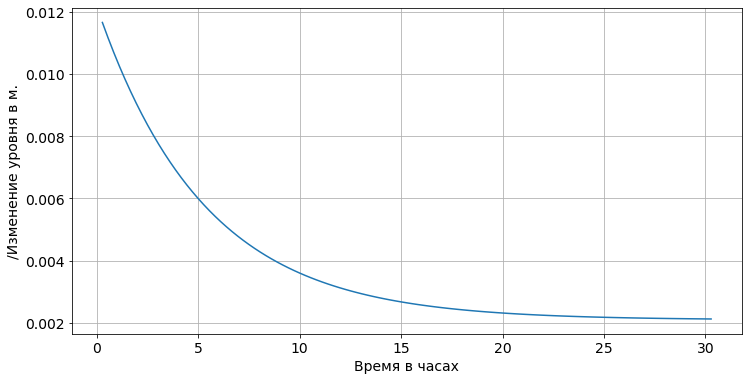

In [19]:
plt.figure(figsize=(12,6))
plt.grid()
#plt.xlim((-0.02,5))
plt.xlabel('Время в часах',fontsize = 14)
plt.ylabel('/Изменение уровня в м.', fontsize = 14)

#plt.xlim(0,20)
plt.tick_params(labelsize=14)
plt.plot(time_in_day,ans2)
plt.savefig('Basic_regul1.png', dpi=300)

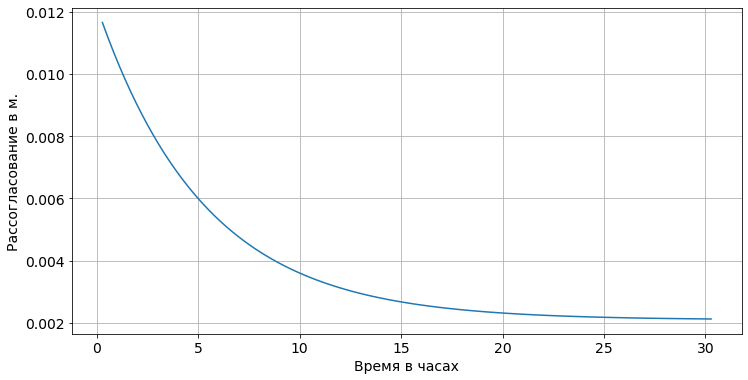

In [20]:
plt.figure(figsize=(12,6))
plt.grid()
#plt.xlim((0,5))
plt.xlabel('Время в часах',fontsize = 14)
plt.ylabel('Рассогласование в м.', fontsize = 14)
#plt.xlim(0,20)
plt.tick_params(labelsize=14)
plt.plot(time_in_day,ans2)
plt.savefig('Basic_gul1.png', dpi=300)

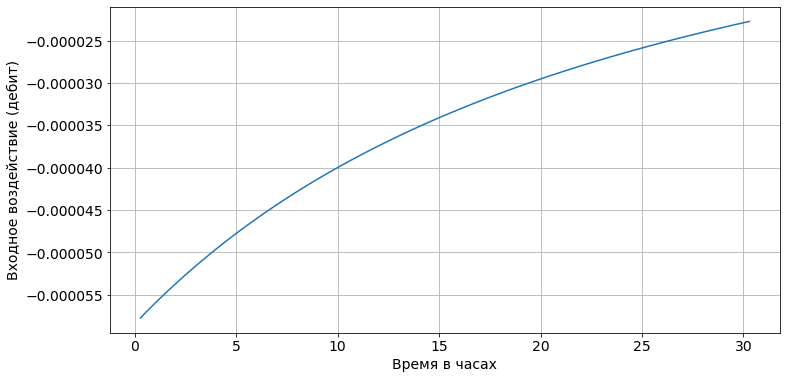

In [21]:
plt.figure(figsize=(12,6))
plt.grid()
#plt.xlim((-0.02,0.02))
plt.xlabel('Время в часах',fontsize = 14)
plt.ylabel('Входное воздействие (дебит)', fontsize = 14)
#plt.xlim(0,20)
plt.tick_params(labelsize=14)
plt.plot(time_in_day,in_)
plt.savefig('Basic_552.png', dpi=300)

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time_in_day,ans2)
axs[1].plot(time_in_day,in_)

In [ ]:
del_tau_ = -150+132

# определение статического коэффициента усиления
Ks = (115.8-116.10) / Q
# Период
T = 2*math.pi/0.00001/3600
# Сдвиг по фазе
fi = 2*math.pi*del_tau_/T

In [ ]:
print('Ks=',Ks, 'T= ',T,'fi= ',fi)

In [ ]:
dz = 1 
# Результат синтеза в ПО:
a1 = 0.00003470
kvz = 263.30354811

In [ ]:
# запас по фазе 
fd = math.pi/4
# можно сделать запас по фазе больше pi/6 например
dd = 2 # 2 декады на параметрическое возмущение
#запас пи/6 лушче

b=np.array(H-Hk)
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import numpy
def makeData ():
    z = numpy.zeros((9,9))
    x = numpy.arange (0, 9, 1)
    y = numpy.arange (0, 9, 1)
    xgrid, ygrid = numpy.meshgrid(x, y)
    #print(xgrid[5])
    #print(type(xgrid))
    for i in range(0,9):
        for k in range(0,9):
            z[i][k] = b[i][k][5]
    zgrid = z
    return xgrid, ygrid, zgrid

x, y, z = makeData()
#print(type(z))
fig = pylab.figure(figsize=(10,6))
axes = Axes3D(fig)
axes.plot_surface(x, y, z, rstride=1, cstride=1, cmap = cm.summer)
axes.set_zlim(-0.35, 0.05)
axes.set_xlabel('x',fontsize=12)
axes.set_ylabel('y',fontsize=12)
axes.set_zlabel('H-Hk,m',fontsize=12)

axes.tick_params(labelsize=12)
pylab.show()
fig.savefig('gist.png', dpi=300)